In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import xgboost as xgb
import pprint

In [3]:
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

## Import Data

In [6]:
#with zipfile.ZipFile('titanic.zip') as myzip:
#    myzip.extractall()

In [6]:
test_df=pd.read_csv('data/test.csv')
train_df=pd.read_csv('data/train.csv')

In [8]:
with open('gender_submission.csv','r') as info:
    file_info=info.read()

In [9]:
pd.set_option('display.max_columns',20)

## Exploration

In [10]:
#test.describe()
#print('-'*40)
train_df.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
total=train_df.isnull().sum().sort_values(ascending=False)
percentage=train_df.isnull().sum()/train_df.isnull().count().sort_values(ascending=False)*100
pd.concat([total,percentage],keys=['Total','Percentage'],axis=1)

,Total,Percentage
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [13]:
train_df.groupby('Sex').Survived.mean().sort_values(ascending=False)

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

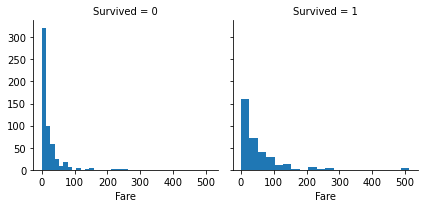

In [14]:
g=sns.FacetGrid(train_df,col='Survived')
g.map(plt.hist,'Fare',bins=20)

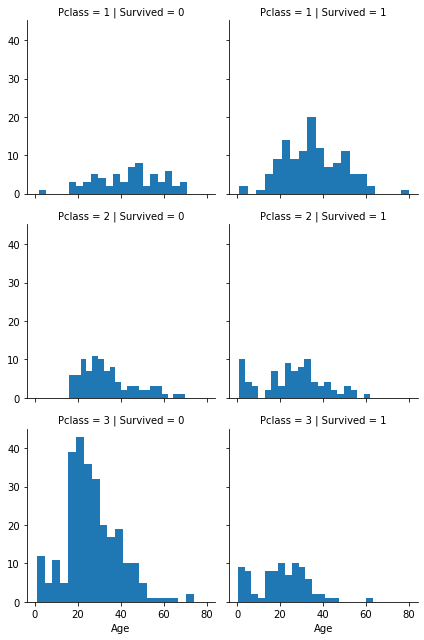

In [15]:
g=sns.FacetGrid(train_df,col='Survived',row='Pclass')
g.map(plt.hist,'Age',bins=20)

<AxesSubplot:xlabel='Survived', ylabel='Fare'>

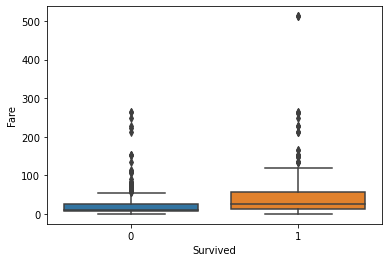

In [16]:
sns.boxplot(train_df.Survived,train_df.Fare)

In [17]:
train_df.groupby('Embarked').Survived.mean().sort_values(ascending=False)

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

<AxesSubplot:>

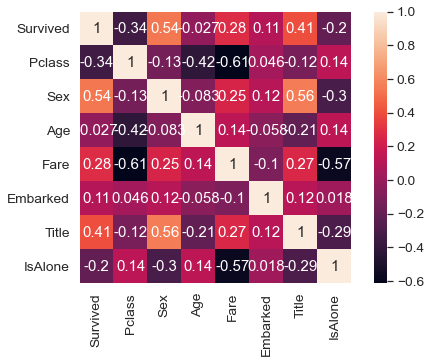

In [146]:
fig,ax=plt.subplots(figsize=(8,5))
corrmat=train_df.corr()
sns.heatmap(corrmat,square=True,annot=True)

<AxesSubplot:>

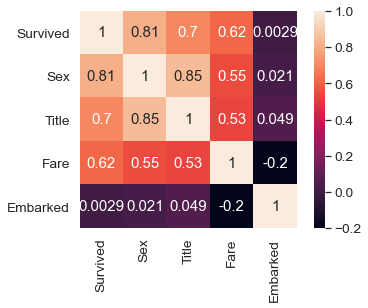

In [147]:
col=corrmat.nlargest(5,'Survived').Survived.index
coef=np.corrcoef(corrmat[col].T)
sns.set(font_scale=1.25)
sns.heatmap(coef,square=True,annot=True,yticklabels=col,xticklabels=col)

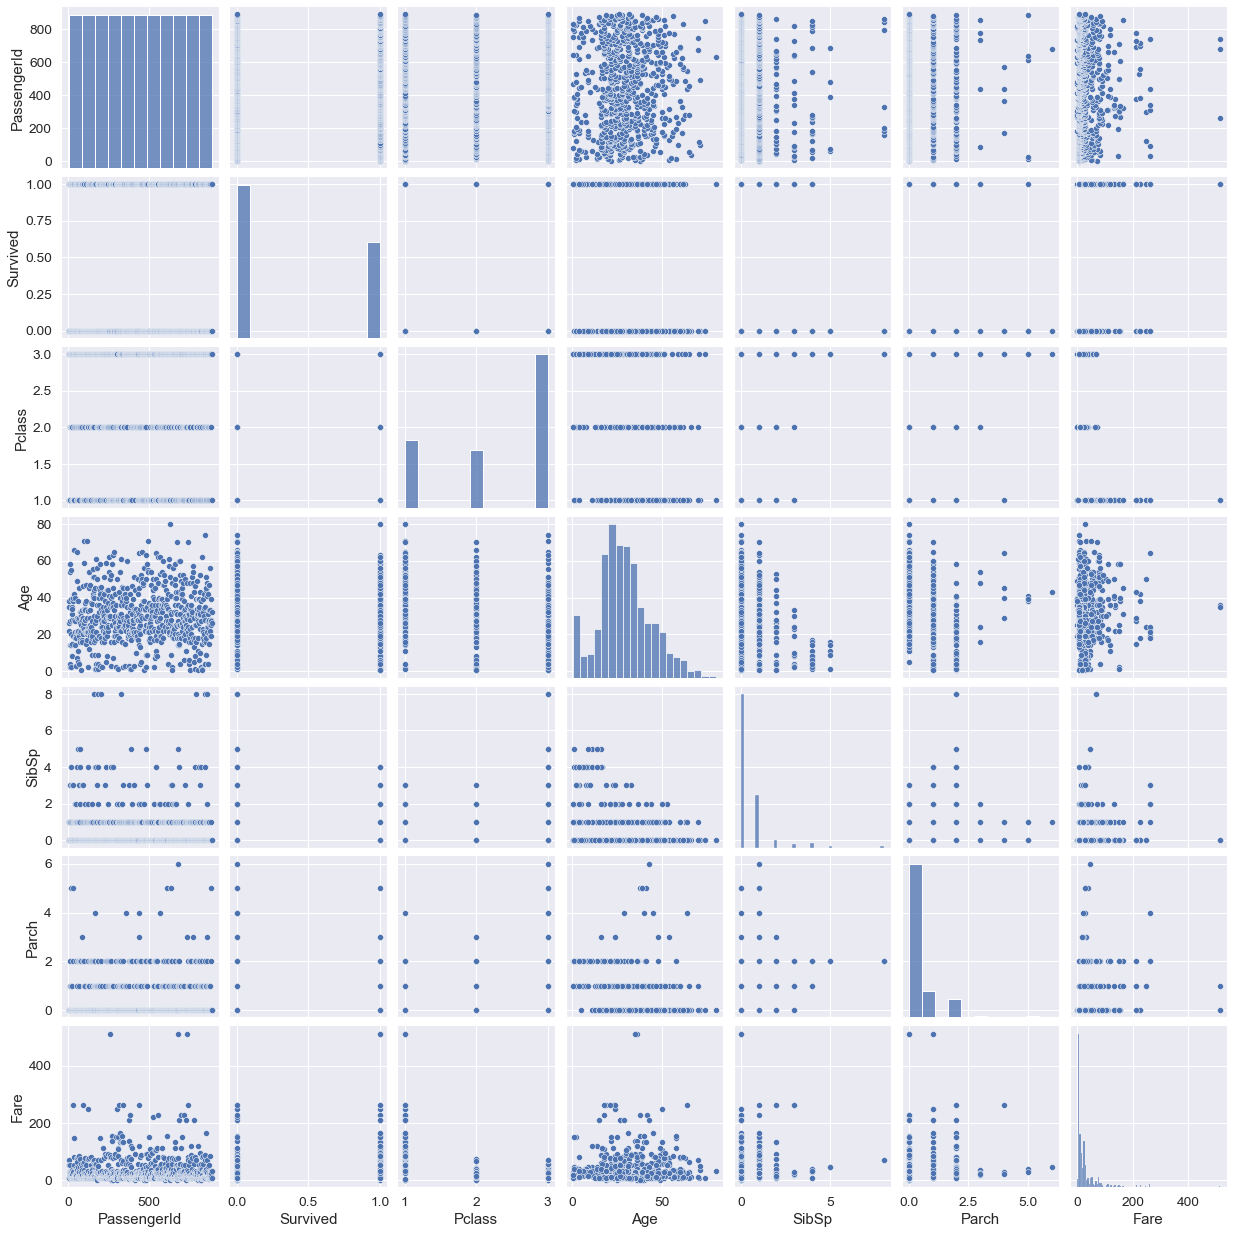

In [20]:
sns.pairplot(train_df,size=2.5)

## Data Engineering

### Drop Columns

In [21]:
# Drop PassengerID
test_df=test_df.drop('PassengerId',axis=1)
train_df=train_df.drop('PassengerId',axis=1)

In [22]:
# Drop Cabin
train_df=train_df.drop('Cabin',axis=1)
test_df=test_df.drop('Cabin',axis=1)

### Create New Columns Title

In [23]:
train_df['Title']=train_df.Name.str.extract('([A-Za-z]+)\.')
test_df['Title']=test_df.Name.str.extract('([A-Za-z]+)\.')

In [24]:
data_all=[train_df,test_df]
for dataset in data_all:    
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [25]:
pd.crosstab(train_df['Title'],train_df['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


### Sex Dummy

In [26]:
data_all=[train_df,test_df]
for dataset in data_all:
    dataset['Sex']=dataset['Sex'].map({'female':1,
                       'male':0})

### Complete Age (Pclass & SibSp)

In [27]:
train_df['Age']=train_df.groupby('Pclass').Age.apply(lambda s: s.fillna(s.median()))
test_df['Age']=test_df.groupby('Pclass').Age.apply(lambda s: s.fillna(s.median()))

In [28]:
train_df['Age']=train_df['Age'].apply(lambda s: int(s))
test_df['Age']=test_df['Age'].apply(lambda s: int(s))

In [29]:
train_df['AgeBand']=pd.cut(train_df['Age'],5)
test_df['AgeBand']=pd.cut(test_df['Age'],5)

In [30]:
train_df[['AgeBand','Survived']].groupby('AgeBand').mean().reset_index()

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


### Create New Columns FamillySize

In [31]:
data_all=[train_df,test_df]
for dataset in data_all:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

In [32]:
data_all=[train_df,test_df]
for dataset in data_all:
    dataset['IsAlone']=0
    dataset.loc[dataset['FamilySize']==1,'IsAlone']=1

### Drop Columns

In [33]:
for dataset in data_all:
    dataset.drop(['Name','SibSp','Parch','Ticket','FamilySize'],axis=1,inplace=True)

### Complete Fare (Numerical)

In [34]:
for dataset in data_all:
    dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].dropna().median())

In [35]:
# Create Fare Band
for dataset in data_all:
    dataset['FareBand']=pd.qcut(dataset['Fare'],4)

### Complete Embarked (Nomial)

In [36]:
for dataset in data_all:
    dataset['Embarked']=dataset['Embarked'].fillna(dataset['Embarked'].dropna().mode()[0])

In [37]:
train_df.iloc[[61,829]]

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,AgeBand,IsAlone,FareBand
61,1,1,1,38,80.0,S,Miss,"(32.0, 48.0]",1,"(31.0, 512.329]"
829,1,1,1,62,80.0,S,Mrs,"(48.0, 64.0]",1,"(31.0, 512.329]"


### Convert to Ordinal Values

In [38]:
train_df.FareBand.unique()

[(-0.001, 7.91], (31.0, 512.329], (7.91, 14.454], (14.454, 31.0]]
Categories (4, interval[float64]): [(-0.001, 7.91] < (7.91, 14.454] < (14.454, 31.0] < (31.0, 512.329]]

In [39]:
# Age
for dataset in data_all:
    dataset.loc[dataset['Age']<16,'Age']=0
    dataset.loc[(dataset['Age']<32) & (dataset['Age']>=16),'Age']=1
    dataset.loc[(dataset['Age']<48) & (dataset['Age']>=32),'Age']=2
    dataset.loc[(dataset['Age']<64) & (dataset['Age']>=48),'Age']=3
    dataset.loc[(dataset['Age']<=80) & (dataset['Age']>=64),'Age']=4

In [40]:
# Fare
for dataset in data_all:
    dataset['Fare_cp']=0
    dataset.loc[dataset['Fare']<=7.91,'Fare_cp']=0
    dataset.loc[(dataset['Fare']<=14.454) & (dataset['Fare']>7.91),'Fare_cp']=1
    dataset.loc[(dataset['Fare']<=31.0) & (dataset['Fare']>14.454),'Fare_cp']=2
    dataset.loc[(dataset['Fare']<=512.329) & (dataset['Fare']>31.0),'Fare_cp']=3

In [41]:
train_df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [42]:
# Title & Embarked
for dataset in data_all:
    dataset['Embarked']=dataset.Embarked.map({'S':0,'C':1,'Q':2})
    dataset['Title']=dataset.Title.map({'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Rare':4})

In [43]:
# Drop columns 
for dataset in data_all:
    dataset['Fare']=dataset['Fare_cp']
    dataset.drop(['Fare_cp','FareBand','AgeBand'],axis=1,inplace=True)

In [106]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  891 non-null    int64
 1   Pclass    891 non-null    int64
 2   Sex       891 non-null    int64
 3   Age       891 non-null    int64
 4   Fare      891 non-null    int64
 5   Embarked  891 non-null    int64
 6   Title     891 non-null    int64
 7   IsAlone   891 non-null    int64
dtypes: int64(8)
memory usage: 55.8 KB


## Models and Training

### Cross_validation

In [65]:
x_train=train_df.drop('Survived',axis=1).values
y_train=train_df.Survived.values
x_test=test_df.copy()

In [269]:
n_folds=5
def cross_v(model):
    kf=KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x_train)
    score=cross_val_score(model,x_train,y_train,cv=kf)
    return score

### Cross_predict

In [192]:
def cross_p(model):
    kf=KFold(n_folds,shuffle=True,random_state=42).get_n_splits(x_train)
    result=cross_val_predict(model,x_train,y_train,cv=kf)
    return result

### Base Models

In [298]:
logreg=LogisticRegression()
#logreg.fit(x_train,y_train)
#result_logreg=logreg.predict(x_test)
#score_logreg=round(logreg.score(x_train,y_train)*100,2)
#score_logreg
#print('Average model score: {:.4f}'.format(score.mean()))

In [300]:
logreg_c=round(cross_v(logreg).mean()*100,2)
logreg_c

79.24

In [91]:
# Validate our decisions and assumptions for feature creating and completing goals
#coeff_df=pd.DataFrame(train_)
coeff_df=pd.DataFrame(train_df.columns.delete(0),columns=['Feature'])
coeff_df['Correlation']=pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation',ascending=False)

,Feature,Correlation
1,Sex,2.199160
5,Title,0.275547
4,Embarked,0.247923
6,IsAlone,-0.070982
3,Fare,-0.096379
2,Age,-0.394499
0,Pclass,-1.214211


In [377]:
# Support Vector Machines
svc=SVC()
svc.fit(x_train,y_train)
result_svc=svc.predict(x_test)
score_svc=round(svc.score(x_train,y_train)*100,2)
score_svc

83.61

In [294]:
svc_c=round(cross_v(svc).mean()*100,2)
svc_c

81.26

In [295]:
## k-Nearest Neighbors algorithm
knn=KNeighborsClassifier(n_neighbors=2)
#knn.fit(x_train,y_train)
#result_knn=knn.predict(x_test)
#score_knn=round(knn.score(x_train,y_train)*100,2)
#score_knn

In [296]:
knn_c=round(cross_v(knn).mean()*100,2)
knn_c

77.11

In [301]:
#Naive Bayes
gaussian=GaussianNB()
#gaussian.fit(x_train,y_train)
#result_gaussian=gaussian.predict(x_test)
#score_gaussian=round(gaussian.score(x_train,y_train)*100,2)
#score_gaussian

In [302]:
gaussian_c=round(cross_v(gaussian).mean()*100,2)
gaussian_c

76.55

In [304]:
perceptron=Perceptron()
#perceptron.fit(x_train,y_train)
#result_perceptron=perceptron.predict(x_test)
#score_perceptron=round(perceptron.score(x_train,y_train)*100,2)
#score_perceptron

In [305]:
perceptron_c=round(cross_v(perceptron).mean()*100,2)
perceptron_c

70.52

In [307]:
# Linear SVC
linear_svc=LinearSVC()
#linear_svc.fit(x_train,y_train)
#result_linear_svc=linear_svc.predict(x_test)
#score_linear_svc=round(linear_svc.score(x_train,y_train)*100,2)
#score_linear_svc

In [308]:
linear_svc_c=round(cross_v(linear_svc).mean()*100,2)
linear_svc_c

78.79

In [309]:
# Stocastic Gradient Descent
sgd=SGDClassifier()
#sgd.fit(x_train,y_train)
#result_sgd=sgd.predict(x_test)
#score_sgd=round(sgd.score(x_train,y_train)*100,2)
#score_sgd

In [310]:
sgd_c=round(cross_v(sgd).mean()*100,2)
sgd_c

77.44

In [311]:
# Decision Tree
decision_t=DecisionTreeClassifier()
#decision_t.fit(x_train,y_train)
#result_decision_t=decision_t.predict(x_test)
#score_decision_t=round(decision_t.score(x_train,y_train)*100,2)
#score_decision_t

In [383]:
decision_t_c=round(cross_v(decision_t).mean()*100,2)
decision_t_c

79.24

In [314]:
# Random Forest
random_forest=RandomForestClassifier(n_estimators=100)
#random_forest.fit(x_train,y_train)
#result_random_forest=random_forest.predict(x_test)
#score_random_forest=round(random_forest.score(x_train,y_train)*100,2)
#score_random_forest

In [315]:
random_forest_c=round(cross_v(random_forest).mean()*100,2)
random_forest_c

79.46

In [316]:
model_score=pd.DataFrame({'Model':['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
             'Score':[svc_c,knn_c,logreg_c,random_forest_c,gaussian_c,perceptron_c,sgd_c,linear_svc_c,decision_t_c]})
model_score.sort_values(by='Score',ascending=False)

,Model,Score
0,Support Vector Machines,81.26
3,Random Forest,79.46
8,Decision Tree,79.35
2,Logistic Regression,79.24
7,Linear SVC,78.79
6,Stochastic Gradient Decent,77.44
1,KNN,77.11
4,Naive Bayes,76.55
5,Perceptron,70.52


In [143]:
# Acquire PassengerId column
sample_sub=pd.read_csv('gender_submission.csv')
p_id=sample_sub.PassengerId

In [378]:
# First Attempt
attempt_1st=pd.DataFrame({'PassengerId':p_id,
             'Survived':result_svc})
attempt_1st.to_csv('Phil_attempt_3rd',index=False)

### Stacking with Base Models with Hyperparams

In [174]:
## Class for classifier code reuse
#n_train=x_train.shape[0]
#n_test=x_test.shape[0]
SEED=0
#nfolds=5
#kf=KFold(nfolds,shuffle=True,random_state=seed)

class SklearnHelper():
    def __init__(self,clf,seed=0,params=None):
        params['random_state']=seed
        self.clf=clf(**params)
    
    def train(self,x_train,y_train):
        self.clf.fit(x_train,y_train)
    
    def predict(self,x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importance(self,x,y):
        print (self.clf.fit(x,y).feature.importances_)

#### Recreate Base Models with SklearnHelper

In [170]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }


In [181]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Stacking Trial

In [214]:
logreg_base=cross_p(logreg)
#svc_base=cross_p(svc)
knn_base=cross_p(knn)
gaussian_base=cross_p(gaussian)
perceptron_base=cross_p(perceptron)
linear_svc_base=cross_p(linear_svc)
sgd_base=cross_p(sgd)
decision_t_base=cross_p(decision_t)
random_forest_base=cross_p(random_forest)

In [221]:
base_prediction_train=pd.DataFrame({'LogisticRegression':logreg_base,
                                   'k-NearestNeighbors':knn_base,
                                   'linearSVC':linear_svc_base,
                                   'SGD':sgd_base,
                                   'DecisionTree':decision_t_base,
                                   'RandomForest':random_forest_base,
                                   'Gaussian':gaussian_base,
                                   'Perceptron':perceptron_base})
base_prediction_train.head()

,LogisticRegression,k-NearestNeighbors,linearSVC,SGD,DecisionTree,RandomForest,Gaussian,Perceptron
0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,1,1
2,1,0,1,0,0,0,1,1
3,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,1


<AxesSubplot:>

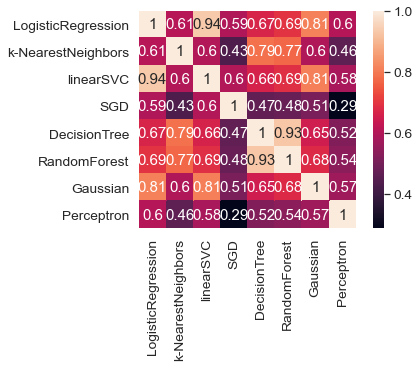

In [222]:
corr=base_prediction_train.corr()
sns.heatmap(corr,square=True,annot=True)

In [231]:
x_train_stack=base_prediction_train.values
y_train_stack=y_train
x_test_stack=pd.DataFrame({'LogisticRegression':result_logreg,
                                   'k-NearestNeighbors':result_knn,
                                   'linearSVC':result_linear_svc,
                                   'SGD':result_sgd,
                                   'DecisionTree':result_decision_t,
                                   'RandomForest':result_random_forest,
                                   'Gaussian':result_gaussian,
                                   'Perceptron':result_perceptron}).values

In [234]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_stack, y_train_stack)
predictions_stack = gbm.predict(x_test_stack)

In [235]:
# Second Attempt
attempt_2nd=pd.DataFrame({'PassengerId':p_id,
             'Survived':predictions_stack})
attempt_2nd.to_csv('Phil_attempt_2nd',index=False)